In [2]:
import pickle

from copy import deepcopy

from geoloc_imc_2023.default import ANCHOR_TARGET_ANCHOR_VP
from geoloc_imc_2023.measurement_utils import load_atlas_anchors
from geoloc_imc_2023.query_api import get_measurement_from_id

## retrieve results

In [ ]:
start = 52591613  
end = 52592569

measurement_results = {}
for id in range(start, end):
    measurement_result = get_measurement_from_id(id)
    measurement_results.update(measurement_result)

In [4]:
# save raw results
with open(ANCHOR_TARGET_ANCHOR_VP, "wb") as f:
    pickle.dump(measurement_results, f)

In [55]:
anchors = load_atlas_anchors()

with open(ANCHOR_TARGET_ANCHOR_VP, "rb") as f:
    measurement_results = pickle.load(f)

print("nb raw results: ", len(measurement_results))

iterator = deepcopy(measurement_results)
for target in iterator:

    # check that target in target dataset
    try:
        target_description = anchors[target]
    except KeyError:
        measurement_results.pop(target)
        continue

    # check that all vps are in vps dataset
    tmp_vps = deepcopy(measurement_results[target])
    for vp in tmp_vps:
        # check that target in target dataset
        try:
            vp_description = anchors[vp]
        except KeyError:
            measurement_results[target].pop(vp)
            continue

        # remove target from vps    
        if vp == target:
            measurement_results[target].pop(vp)

    # check that sufficient number of measurements
    if len(measurement_results[target]) < 500:
        measurement_results.pop(target)

print("nb target measurements after filtering:", len(measurement_results))

for i, target in enumerate(measurement_results):
    if i > 10: break
    print(f"target: {target}, nb_measurements :{len(measurement_results[target])}")

nb raw results:  774
nb target measurements after filtering: 774
target: 217.29.76.27, nb_measurements :772
target: 192.172.226.235, nb_measurements :771
target: 76.26.115.194, nb_measurements :770
target: 50.28.98.185, nb_measurements :771
target: 37.10.126.72, nb_measurements :773
target: 185.111.204.121, nb_measurements :770
target: 103.121.34.150, nb_measurements :769
target: 216.171.184.239, nb_measurements :772
target: 129.122.18.18, nb_measurements :772
target: 92.38.135.131, nb_measurements :771
target: 83.212.7.42, nb_measurements :772


In [56]:
for target in measurement_results:
    for vp in measurement_results[target]:
        anchors[vp]

In [80]:
# save raw results
with open(ANCHOR_TARGET_ANCHOR_VP, "wb") as f:
    pickle.dump(measurement_results, f)

# 4.1.1 A Few VPs Can Be Accurate

In [1]:
import pickle
import logging
import itertools
import numpy as np 
from collections import OrderedDict

from geoloc_imc_2023.default import ANCHOR_TARGET_ANCHOR_VP
from geoloc_imc_2023.measurement_utils import load_atlas_anchors
from geoloc_imc_2023.helpers import select_best_guess_centroid, haversine

NB_TRIAL = 100

logger = logging.getLogger()

In [10]:
# load results
with open(ANCHOR_TARGET_ANCHOR_VP, "rb") as f:
    measurement_results = pickle.load(f)

# load vps and targets dataset (here only anchors)
anchors = load_atlas_anchors()

In [11]:
print(len(measurement_results))
for target in measurement_results:
    copy_results = deepcopy(measurement_results[target])
    for vp, results in copy_results.items():
        if isinstance(results["min_rtt"], str):
            measurement_results[target].pop(vp)

    measurement_results[target] = OrderedDict(
        {
            vp: results
            for vp, results in sorted(
                measurement_results[target].items(),
                key=lambda item: item[1]["min_rtt"],
            )
        }
    )

773


In [12]:
# save raw results
with open(ANCHOR_TARGET_ANCHOR_VP, "wb") as f:
    pickle.dump(measurement_results, f)

In [15]:
for i, target in enumerate(measurement_results):
    if i > 10: break
    copy = deepcopy(measurement_results)
    for vp in measurement_results[target]:
        print(measurement_results[target][vp])
    print()

{'node': '92.223.93.208', 'min_rtt': 0.893629, 'rtt_list': [1.276443, 0.893629, 1.867573]}
{'node': '194.187.174.6', 'min_rtt': 1.223099, 'rtt_list': [1.223099, 1.472204, 1.910688]}
{'node': '109.168.125.243', 'min_rtt': 1.374996, 'rtt_list': [1.427646, 1.374996, 1.375125]}
{'node': '185.78.49.100', 'min_rtt': 3.355421, 'rtt_list': [4.688363, 3.355421, 3.506749]}
{'node': '213.212.129.68', 'min_rtt': 3.981136, 'rtt_list': [4.279228, 3.981136, 4.177651]}
{'node': '194.116.77.35', 'min_rtt': 4.006032, 'rtt_list': [4.377572, 4.006032, 4.089872]}
{'node': '212.103.84.18', 'min_rtt': 4.973216, 'rtt_list': [4.973216, 5.174825, 4.980958]}
{'node': '194.242.34.190', 'min_rtt': 4.978451, 'rtt_list': [5.186184, 5.165026, 4.978451]}
{'node': '185.17.70.76', 'min_rtt': 5.136433, 'rtt_list': [5.136433, 42.330871, 5.24499]}
{'node': '193.36.105.129', 'min_rtt': 5.206548, 'rtt_list': [5.514784, 5.328473, 5.206548]}
{'node': '77.109.180.62', 'min_rtt': 5.346424, 'rtt_list': [5.346424, 5.435291, 5.5625

In [3]:
def get_results_from_set(vp_set: set, target_results: dict) -> dict:
    measurement_set = {}
    for vp in vp_set:
        # some targets might not have vps in their result
        try:
            measurement_set[vp] = target_results[vp]
        except KeyError:
            continue
        
    return measurement_set

def get_shortest_ping_result(measurement_set: dict) -> tuple:
    """return the position of the vantage point with shortest ping measurement"""
    shortest_ping = float('inf')
    closest_vp = None
    for vp, result in measurement_set.items():
        if shortest_ping > result['min_rtt']:
            shortest_ping = result['min_rtt']
            closest_vp = vp
    
    return closest_vp, shortest_ping

def get_dst_error(vp_subset: set,measurement_results: dict, target_dataset: dict,vp_dataset:dict) -> list:
    """from a set of measurement return shortest Ping and CBG distance error"""

    cbg_d_error_list = []
    shortest_ping_d_error_list = []

    cbg_dst_errors = {}
    shortest_ping_dst_errors = {}

    for target_addr in measurement_results:
        target_results = measurement_results[target_addr]
        measurement_set = get_results_from_set(vp_subset, target_results)

        # if len(measurement_set) != len(vp_subset):
        #     print("missing vps in results")

        intersection, centroid = select_best_guess_centroid(measurement_set, vp_dataset)
        closest_vp, min_rtt = get_shortest_ping_result(measurement_set)

        # compute distance error
        dst_error = haversine(
            (
                target_dataset[target_addr]["latitude"], 
                target_dataset[target_addr]["longitude"]
            ), 
            centroid
        )

        cbg_dst_errors[target_addr] = dst_error
        cbg_d_error_list.append(dst_error)
        
        # shortest ping
        dst_error = haversine(
            (
                target_dataset[target_addr]["latitude"], 
                target_dataset[target_addr]["longitude"]
            ), 
            (
                vp_dataset[closest_vp]["latitude"], 
                vp_dataset[closest_vp]["longitude"]
            ), 
        )
        shortest_ping_dst_errors[target_addr] = dst_error
        shortest_ping_d_error_list.append(dst_error)


    return cbg_dst_errors, shortest_ping_dst_errors, cbg_d_error_list, shortest_ping_d_error_list

In [ ]:
cbg_results = {}
shortest_ping_results = {}

for vp_set_size in range(5,len(anchors), 5):
    i = 0

    subset_results_cbg = {}
    subset_results_shortest_ping = {}

    subset_results_cbg_list = []
    subset_results_shortest_ping_list = []
    for vp_subset in itertools.combinations(anchors, vp_set_size):
        if i > NB_TRIAL: break
        i += 1

        # TODO: check validity of vp set (geolocation, diversity)
        (
            cbg_dst_errors, 
            shortest_ping_dst_errors,
            cbg_dst_errors_list,
            shortest_ping_dst_errors_list,
        ) = get_dst_error(
            vp_subset = vp_subset,
            measurement_results = measurement_results,
            target_dataset = anchors,
            vp_dataset = anchors,
        )

        subset_results_cbg[tuple(vp_subset)] = cbg_dst_errors
        subset_results_shortest_ping[tuple(vp_subset)] = shortest_ping_dst_errors

        subset_results_cbg_list.extend(cbg_dst_errors_list)
        subset_results_shortest_ping_list.extend(shortest_ping_dst_errors_list)

    
    print(f"subset size: {vp_set_size} done")
    
    median_error_cbg = np.median(subset_results_cbg_list)
    median_error_shortest_ping = np.median(subset_results_shortest_ping_list)

    # get the standard deviation over all trials
    deviation_cbg = np.std(subset_results_cbg_list)
    deviation_shortest_ping = np.std(subset_results_shortest_ping_list)
    
    cbg_results[vp_set_size] = {
        "median_error" : median_error_cbg,
        "deviation" : deviation_cbg,
        "data": subset_results_cbg,
    }
    shortest_ping_results[vp_set_size] = {
        "median_error" : median_error_shortest_ping,
        "deviation" : deviation_shortest_ping,
        "data" : subset_results_shortest_ping,
    }

In [19]:
for vp_set_size in cbg_results:
    print(f"{vp_set_size} : median error: {cbg_results[vp_set_size]['median_error']}; deviation: {cbg_results[vp_set_size]['deviation']}")
    print(f"{vp_set_size} : median error: {shortest_ping_results[vp_set_size]['median_error']}; deviation: {shortest_ping_results[vp_set_size]['deviation']}")
    print()

5 : median error: 1344.0893316582521; deviation: 4510.313430066133
5 : median error: 1120.3673316769166; deviation: 4153.007318193155

10 : median error: 756.8681613488425; deviation: 3730.498058558161
10 : median error: 575.5964331411035; deviation: 3601.845904978113

15 : median error: 623.3390419722222; deviation: 3227.476394467192
15 : median error: 514.5158472369279; deviation: 3045.5655529959927

20 : median error: 561.9973287600129; deviation: 3419.241053017129
20 : median error: 452.6382223394924; deviation: 2932.8672882632836

25 : median error: 489.15721715418886; deviation: 2090.7968197121168
25 : median error: 397.42992049837886; deviation: 1739.8282160820738

30 : median error: 473.7506176585952; deviation: 2114.6093809456593
30 : median error: 394.484264454919; deviation: 1746.123858496521

35 : median error: 438.8644346169059; deviation: 2055.804499211457
35 : median error: 387.1828915506109; deviation: 1696.5797504518955

40 : median error: 426.3692934219735; deviation:

In [20]:
from pathlib import Path

print(len(cbg_dst_errors))
print(len(shortest_ping_dst_errors))

figure2a_results = {}
figure2a_results["cbg"] = cbg_results
figure2a_results["shortest_ping"] = shortest_ping_results

result_path = Path(".") / "../result/figure2a.pickle"
with open(result_path, "wb") as f:
    pickle.dump(figure2a_results, f) 

773
773


In [3]:
from pathlib import Path

result_path = Path(".") / "../result/figure2a.pickle"
with open(result_path, "rb") as f:
    figure2a_results = pickle.load(f) 

In [6]:
print(len(figure2a_results["cbg"]))

65


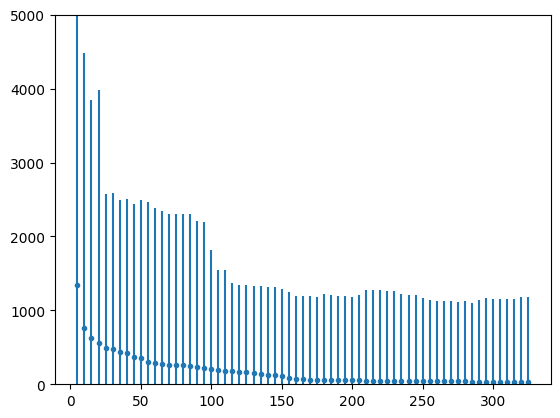

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


nb_samples = len(figure2a_results["cbg"]) + 1
step = 5

x = np.array([i for i in range(step, step * nb_samples, step)])
y = np.array([figure2a_results["cbg"][vp_set_size]['median_error'] for vp_set_size in figure2a_results["cbg"]])
e = np.array([figure2a_results["cbg"][vp_set_size]['deviation'] for vp_set_size in figure2a_results["cbg"]])
plt.ylim((0, 5000))
plt.errorbar(x, y, e, linestyle='None', marker=".")


plt.show()

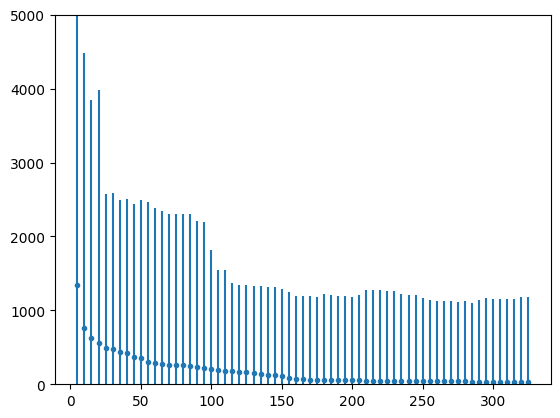

In [10]:
nb_samples = len(figure2a_results["shortest_ping"]) + 1
step = 5

x2 = np.array([i for i in range(step, step * nb_samples, step)])
y2 = np.array([figure2a_results["shortest_ping"][vp_set_size]['median_error'] for vp_set_size in figure2a_results["shortest_ping"]])
e2 = np.array([figure2a_results["shortest_ping"][vp_set_size]['deviation'] for vp_set_size in figure2a_results["shortest_ping"]])
plt.ylim((0, 5000))
plt.errorbar(x, y, e, linestyle='None', marker='.')

plt.show()

In [11]:
import pandas as pd

def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

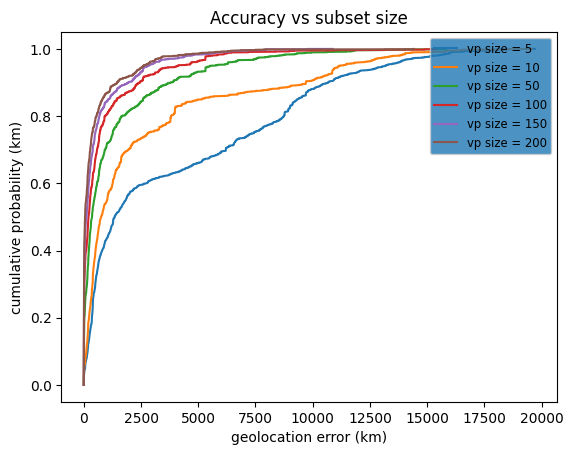

In [13]:
import seaborn as sns


fig, ax = plt.subplots()

for vp_set_size in [5,10,50,100, 150, 200]:
    subset_results = []
    for vp_subset in figure2a_results["cbg"][vp_set_size]["data"]:
        for target_addr, d_error in figure2a_results["cbg"][vp_set_size]["data"][vp_subset].items():
            subset_results.append(d_error)
        
    x,y = ecdf(subset_results)
    ax.plot(x,y, label = f"vp size = {vp_set_size}")


legend = ax.legend(loc='upper right', fontsize='small')
legend.get_frame().set_facecolor('C0')
plt.xlabel("geolocation error (km)")
plt.ylabel("cumulative probability (km)")
plt.title("Accuracy vs subset size")
plt.show()


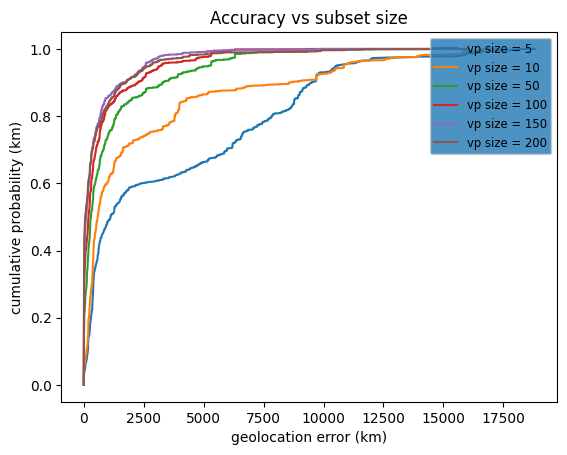

In [14]:
import seaborn as sns


fig, ax = plt.subplots()

for vp_set_size in [5,10,50,100, 150, 200]:
    subset_results = []
    for vp_subset in figure2a_results["shortest_ping"][vp_set_size]["data"]:
        for target_addr, d_error in figure2a_results["shortest_ping"][vp_set_size]["data"][vp_subset].items():
            subset_results.append(d_error)
        
    x,y = ecdf(subset_results)
    ax.plot(x,y, label = f"vp size = {vp_set_size}")


legend = ax.legend(loc='upper right', fontsize='small')
legend.get_frame().set_facecolor('C0')
plt.xlabel("geolocation error (km)")
plt.ylabel("cumulative probability (km)")
plt.title("Accuracy vs subset size (shortest)")
plt.show()

In [17]:
for target_addr in measurement_results:
    target_results = measurement_results[target_addr]
    measurement_set = get_results_from_set(vp_subset, target_results)

    # if len(measurement_set) != len(vp_subset):
    #     print("missing vps in results")

    intersection, centroid = select_best_guess_centroid(measurement_set, vp_dataset)
    closest_vp, min_rtt = get_shortest_ping_result(measurement_set)

    # compute distance error
    dst_error = haversine(
        (
            target_dataset[target_addr]["latitude"], 
            target_dataset[target_addr]["longitude"]
        ), 
        centroid
    )

    cbg_dst_errors[target_addr] = dst_error
    cbg_d_error_list.append(dst_error)
    
    # shortest ping
    dst_error = haversine(
        (
            target_dataset[target_addr]["latitude"], 
            target_dataset[target_addr]["longitude"]
        ), 
        (
            vp_dataset[closest_vp]["latitude"], 
            vp_dataset[closest_vp]["longitude"]
        ), 
    )
    shortest_ping_dst_errors[target_addr] = dst_error
    shortest_ping_d_error_list.append(dst_error)

## figure 5

In [4]:
def select_closest_vp(prefix_results: dict, nb_vps: int) -> set:
    """from a set of results for a given target, return closest vps"""
    closest_results = {}
    for i, vp in enumerate(prefix_results) :
        if i <= nb_vps: break
        closest_results[vp] = prefix_results[vp]
    return closest_results

# load results
with open(ANCHOR_TARGET_ANCHOR_VP, "rb") as f:
    measurement_results = pickle.load(f)

# load vps and targets dataset (here only anchors)
anchors = load_atlas_anchors()

fig5_all_vps = {}
fig5_closest_vps = {}
for target_addr in measurement_results:
    target_results = measurement_results[target_addr]

    closest_results = select_closest_vp(target_results, nb_vps= 10)

    closest_vps_centroid = select_best_guess_centroid(closest_results, anchors)
    all_vps_centroid = select_best_guess_centroid(target_results, anchors)

    # compute distance error
    dst_error_closest = haversine(
        (
            anchors[target_addr]["latitude"], 
            anchors[target_addr]["longitude"]
        ), 
        closest_vps_centroid
    )
        
    # shortest ping
    dst_error_all = haversine(
        (
            anchors[target_addr]["latitude"], 
            anchors[target_addr]["longitude"]
        ), 
        all_vps_centroid,
    )

    fig5_all_vps[target_addr] = dst_error_closest
    fig5_closest_vps[target_addr] = dst_error_all    

KeyError: None

## Get measurements

In [ ]:
import logging
import pickle

from collections import defaultdict

from geoloc_imc_2023.query_api import get_measurements_from_tag
from geoloc_imc_2023.cbg import get_prefix_from_ip

In [ ]:
uuid = "91d6e4de-8ce6-4fb6-a835-285b0aed82f6"
uuid = "79213f8c-d3b9-4f95-a15-a8f9654fcf51"
uuid = "93d4b015-4ff6-462a-bf35-10050f9a8a6c"
uuid = "ce9d52a7-c83b-4e03-b9b0-3883d4165c9f"
uuid = "adb36b03-f411-4109-8af2-a080e6a26464"
uuii = "ce9d52a7-c83b-4e03-b9b0-3883d4165c9f"

measurement_results = get_measurements_from_tag(uuid)


In [ ]:
print(len(measurement_results))
prefix_measurements = defaultdict(list)
for i, (target_addr, result) in enumerate(measurement_results.items()):
    if i < 10: print(target_addr, result)
    target_prefix = get_prefix_from_ip(target_addr)
    prefix_measurements[target_prefix].append({
        "target_addr": target_addr,
        "result": result,
    })

658
23.161.80.9 [{'node': '185.33.216.12', 'min_rtt': 123.166616, 'rtt_list': [123.259974, 123.166616, 123.229249]}, {'node': '23.131.160.206', 'min_rtt': 0.548502, 'rtt_list': [0.548502, 0.635978, 0.616699]}, {'node': '91.240.92.5', 'min_rtt': 135.000615, 'rtt_list': [135.175551, 135.000615, 135.095447]}, {'node': '185.201.145.118', 'min_rtt': 151.201974, 'rtt_list': [151.271032, 151.270866, 151.201974]}, {'node': '5.28.0.17', 'min_rtt': 150.506007, 'rtt_list': [150.60381, 150.506007, 150.537488]}, {'node': '193.171.255.2', 'min_rtt': 146.479779, 'rtt_list': [146.728445, 146.479779, 146.568507]}, {'node': '192.65.184.54', 'min_rtt': 139.205187, 'rtt_list': [139.225678, 139.224332, 139.205187]}, {'node': '185.42.136.158', 'min_rtt': 149.388286, 'rtt_list': [149.473235, 149.388286, 149.397562]}, {'node': '197.80.104.36', 'min_rtt': 300.04277, 'rtt_list': [300.045205, 300.04277, 300.111196]}, {'node': '200.7.84.24', 'min_rtt': 195.907622, 'rtt_list': [198.259997, 199.44837, 195.907622]},

In [ ]:
print(len(prefix_measurements))
for i, target_prefix in enumerate(prefix_measurements):
    if i <  5: 
        print("target prefix: ", target_prefix)
        for target_result in prefix_measurements[target_prefix]:
            print(f"target: {target_result['target_addr']} : {target_result['result']}")

762
target prefix:  23.161.80.0
target: 23.161.80.9 : [{'node': '185.33.216.12', 'min_rtt': 123.166616, 'rtt_list': [123.259974, 123.166616, 123.229249]}, {'node': '23.131.160.206', 'min_rtt': 0.548502, 'rtt_list': [0.548502, 0.635978, 0.616699]}, {'node': '91.240.92.5', 'min_rtt': 135.000615, 'rtt_list': [135.175551, 135.000615, 135.095447]}, {'node': '185.201.145.118', 'min_rtt': 151.201974, 'rtt_list': [151.271032, 151.270866, 151.201974]}, {'node': '5.28.0.17', 'min_rtt': 150.506007, 'rtt_list': [150.60381, 150.506007, 150.537488]}, {'node': '193.171.255.2', 'min_rtt': 146.479779, 'rtt_list': [146.728445, 146.479779, 146.568507]}, {'node': '192.65.184.54', 'min_rtt': 139.205187, 'rtt_list': [139.225678, 139.224332, 139.205187]}, {'node': '185.42.136.158', 'min_rtt': 149.388286, 'rtt_list': [149.473235, 149.388286, 149.397562]}, {'node': '197.80.104.36', 'min_rtt': 300.04277, 'rtt_list': [300.045205, 300.04277, 300.111196]}, {'node': '200.7.84.24', 'min_rtt': 195.907622, 'rtt_list':

In [ ]:
from geoloc_imc_2023.default import ANCHOR_PREFIX_ANCHOR_VP

with open(ANCHOR_PREFIX_ANCHOR_VP, "rb") as f:
    cached_result = pickle.load(f)

print(len(cached_result))
print(len(prefix_measurements))

prefix_measurements.update(cached_result)

print(len(prefix_measurements))


533
229
762


In [ ]:
with open(ANCHOR_PREFIX_ANCHOR_VP,"wb") as f:
    pickle.dump(prefix_measurements, f)

In [ ]:
import pickle
from copy import deepcopy

from collections import defaultdict

anchors_file = "../datasets/anchors.pickle"
anchors_measurement_file = "../results/anchors_to_anchors_measurements.pickle"

with open(anchors_file, "rb") as f:
    anchors = pickle.load(f)

# load already existing measurements
with open(anchors_measurement_file, "rb") as f:
    anchor_measurements = pickle.load(f)


# sfor debugging, print some results
filtered_results = deepcopy(anchor_measurements)
for i, anchor in enumerate(filtered_results):
    if i > 10: break
    print(f"target ip: {anchor}, number of measurements: {len(anchor_measurements[anchor]['result'][0])}")
    
with open(anchors_measurement_file, "wb") as f:
    pickle.dump(anchor_measurements, f)

target ip: 129.13.73.54, number of measurements: 775
target ip: 152.195.112.52, number of measurements: 775
target ip: 193.46.104.17, number of measurements: 772
target ip: 200.3.170.54, number of measurements: 775
target ip: 195.30.70.33, number of measurements: 775
target ip: 86.38.3.141, number of measurements: 769
target ip: 77.110.218.255, number of measurements: 774
target ip: 156.154.135.254, number of measurements: 772
target ip: 34.89.240.90, number of measurements: 766
target ip: 34.68.239.153, number of measurements: 767
target ip: 195.130.66.103, number of measurements: 774


## select dataset

In [ ]:
from random import choice

NB_TARGET = 2_00 # testing
NB_VP = 1 # testing

# select targets and vps from anchors
targets= [choice(list(anchor_measurements)) for _ in range(0, NB_TARGET)]
vps = list(set(anchor_measurements).difference(set(targets)))

analysis_dataset = {}
for i, target_addr in enumerate(targets):

    # select measurement where source is in vps
    measurement_results = []
    for result in anchor_measurements[target_addr]['result'][0]:

        if result['node'] in vps:
            measurement_results.append(result)
        
    analysis_dataset[target_addr] = measurement_results

## analyze data

In [ ]:
from pathlib import Path
import pickle
from copy import copy

from geoloc_imc_2023.helpers import polygon_centroid, haversine, circle_intersections
from geoloc_imc_2023.draw_results import draw_results

def select_best_guess_centroid(target_addr, measurement_results):
    """
    Find the best guess
    that is the location of the vantage point closest to the centroid.
    """
    probe_circles = {}
    print(f"NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: {target_addr} : {len(measurement_results)}")
    for _, result in enumerate(measurement_results):
        vp_ip = result["node"]
        lat = result["vp_lat"]
        lon = result["vp_lon"]
        min_rtt = result["min_rtt"]

        # too inflated RTT means that measurement will not provide usefull info
        if isinstance(min_rtt, float):
                probe_circles[vp_ip] = (
                    lat,
                    lon,
                    min_rtt,
                    None,
                    None,
                )
                # print(f"vp_anchor = {vp_ip} with results: {min_rtt}")
    # print()

    # draw circles
    if not probe_circles: return

    intersections = circle_intersections(probe_circles.values(), speed_threshold=4/9)
    #print("intersecion:", intersections)
    target = (anchors[target_addr]["latitude"], anchors[target_addr]["longitude"])

    centroid = None
    if intersections:
        centroid = polygon_centroid(intersections)
        #print("centroid:", centroid)
        target_description = anchors[target_addr]

        if centroid:
            for ip_src, circle in probe_circles.items():

                measured_d = haversine((circle[0], circle[1]), centroid)
                calculated_d = haversine((target_description["latitude"], target_description["longitude"]), centroid)

                #print("ip_src:",ip_src,"dst (measured):", measured_d, "dst (calculated):", calculated_d)
    
    # draw_results(copy(probe_circles), intersections,centroid, target)

    return centroid

anchor_file = "../datasets/anchors.pickle"
with open(anchor_file, "rb") as f:
    anchors = pickle.load(f)

geoloc_results_subset_vps = {}
geoloc_results_all_vps = {}
nb_vps = 10
for i, target_addr in enumerate(analysis_dataset):

    print("available measurements for ip:",len(analysis_dataset[target_addr]))

    subset_vps = analysis_dataset[target_addr][:nb_vps]
    all_vps = analysis_dataset[target_addr]

    centroid = select_best_guess_centroid(target_addr, subset_vps)
    if centroid:
        geoloc_results_subset_vps[target_addr] = {
            "estimated_lat": centroid[0],
            "estimated_lon": centroid[1],
        }

    centroid = select_best_guess_centroid(target_addr, all_vps)
    if centroid:
        geoloc_results_all_vps[target_addr] = {
            "estimated_lat": centroid[0],
            "estimated_lon": centroid[1],
        }

available measurements for ip: 597
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 23.157.112.121 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 23.157.112.121 : 597
2 circles, case is not handled yet
available measurements for ip: 599
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 141.98.136.85 : 10
only one circle found with coordinates: (50.1385, 8.7385, 0.37118, 49.49066666666667, 0.007768115942028986)
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 141.98.136.85 : 599
2 circles, case is not handled yet
available measurements for ip: 601
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 139.180.132.31 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 139.180.132.31 : 601
2 circles, case is not handled yet
available measurements for ip: 601
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 109.168.125.243 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 109.168.125.243 : 601
2 circles, case is

In [ ]:
print(len(geoloc_results_all_vps))
print(len(geoloc_results_subset_vps))

128
129


In [ ]:
geoloc_out_file_subset_vps = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_subset.pickle"
with open(geoloc_out_file_subset_vps, "wb") as f:
    pickle.dump(geoloc_results_subset_vps, f)

geoloc_out_file_all_vps = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_all.pickle"
with open(geoloc_out_file_all_vps, "wb") as f:
    pickle.dump(geoloc_results_all_vps, f)

## output metrics

In [ ]:
from geoloc_imc_2023.helpers import distance

geoloc_out_file_subset = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_subset.pickle"
with open(geoloc_out_file_subset, "rb") as f:
    geoloc_results_subset = pickle.load(f)

geoloc_out_file_all = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_all.pickle"
with open(geoloc_out_file_all, "rb") as f:
    geoloc_results_all = pickle.load(f)


def get_distance_error(geoloc_results) -> dict:
    """from a set of target ip and estimated distance return error distanvce"""
    d_error = {}
    for i, target_addr in enumerate(geoloc_results):
    
        target_lat = anchors[target_addr]["latitude"]
        target_lon = anchors[target_addr]["longitude"]

        estimated_lat = geoloc_results[target_addr]["estimated_lat"]
        estimated_lon = geoloc_results[target_addr]["estimated_lon"]

        d_error[target_addr] = distance(target_lat, estimated_lat, target_lon, estimated_lon)

    return d_error

d_error_subset = get_distance_error(geoloc_results_subset)
d_error_all = get_distance_error(geoloc_results_all)

129
128


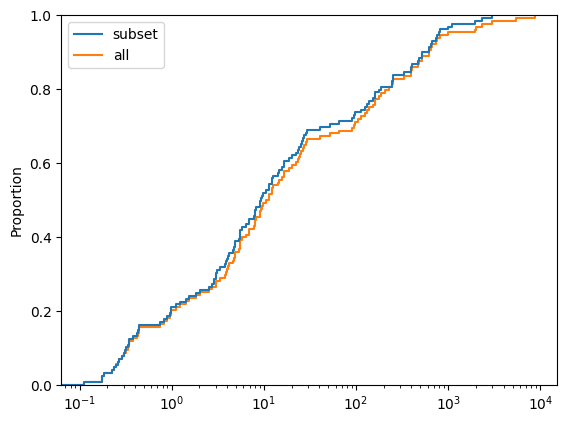

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


data = {
    "subset" : d_error_subset,
    "all": d_error_all
}

cdf_d_error = sns.ecdfplot(data)
plt.xscale('log')
plt.show()